### Set GPU clocks

In [ ]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

In [1]:
from core import *
from torch_backend import *

### Network definition

In [2]:
def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def residual(c, **kw):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c, **kw),
        'res2': conv_bn(c, c, **kw),
        'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')]),
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),

        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

losses = {
    'loss':  (nn.CrossEntropyLoss(reduce=False), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Download and preprocess data

In [3]:
DATA_DIR = './data'
dataset = cifar10(root=DATA_DIR)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.9 seconds
Preprocessing test data
Finished in 0.15 seconds


### Network visualisation

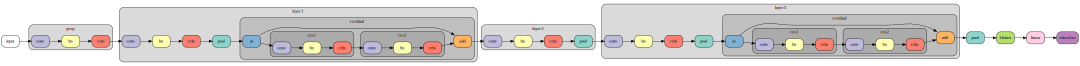

In [ ]:
display(DotGraph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [ ]:
epochs=24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 5

train_batches = Batches(Transform(train_set, transforms), batch_size, shuffle=True, set_random_choices=True, drop_last=True)
test_batches = Batches(test_set, batch_size, shuffle=False, drop_last=False)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = Network(union(net(), losses)).to(device).half()
    opt = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
    summaries.append(train(model, opt, train_batches, test_batches, epochs, loggers=(TableLogger(),)))

test_accs = np.array([s['test acc'] for s in summaries])
print(f'mean test accuracy: {np.mean(test_accs):.4f}')
print(f'median test accuracy: {np.median(test_accs):.4f}')
print(f'{np.sum(test_accs>=0.94)}/{N_runs} >= 94%')

Starting Run 0 at 2018-12-04 16:36:29
       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       4.2188       1.6095       0.4167       0.4228       1.4103       0.5157       4.6416
           2       0.1600       2.9172       0.9291       0.6712       0.2854       0.8575       0.7107       7.8441
           3       0.2400       2.9170       0.7249       0.7455       0.2260       0.8204       0.7263      10.9871
           4       0.3200       2.9177       0.6237       0.7836       0.2259       0.6574       0.7718      14.1306
           5       0.4000       2.9189       0.5514       0.8089       0.2262       0.7334       0.7503      17.2757
           6       0.3789       2.9205       0.4934       0.8316       0.2262       0.6091       0.7845      20.4224
           7       0.3579       2.9619       0.4416       0.8492       0.2261       0.4791       0.8369      23.6104
           8       0.3368 